In [1]:
# data processing packages
import numpy as np   
import pandas as pd 
import scipy as sp

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import IPython
from IPython.display import display

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')
import itertools

import random

# machine leanring packages
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [ ]:
# TO DO:
# change dection:
# causal dependence:

# HMM
# Markov chain
# LSTM 

# sequence to real-value:  sequence to predict power consumption 


# Neural Models for Modeling and Predicting Information Interaction Behavior 

# # Stl: A seasonal-trend decomposition procedure based on loess

# SOC decreasing on stable state 

In [2]:
def multivariate_ts_plot( dta_df, title_str ):
        
    matplotlib.rcParams.update({'font.size': 15})
    figure_size = (15.4,7)
    legend_font = 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )
    
    tmpt = range(dta_df.shape[0])
    for i in dta_df.columns:
        
        tmpx = list(dta_df[i])    
        plt.plot( tmpt, tmpx, label= i )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    axes.set_ylim([-200, 300])

    # plt.plot( list( clean_tdf['value']), color='g' )

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title( title_str )
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )
    
    
# parse timestamp to extract seconds
def month_tick( month  ):
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31 ]    
    return sum(days[:month-1])*3600*24

def day_tick( day ):
    return (day-1)*3600*24

def hour_tick( hour ):
    return hour*3600

def minutes_tick( minute ):    
    return minute*60

def cal_second_tick( tup, bias ):
    tmp_len = len(tup[4])
    
    return float(tup[0])*0 + month_tick( int(tup[1]) ) +  day_tick( float(tup[2]) ) + \
           hour_tick( float(tup[3]) ) \
           + minutes_tick( float(tup[4][ tmp_len-5 : tmp_len-3 ]) ) + float(tup[4][ tmp_len-2 : tmp_len ]) - bias
    
    
def build_second_col( dta_df, bias ):
    tmpdta = dta_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'RECEIVETIME']]
    
    return tmpdta.apply( lambda x: cal_second_tick(x, bias), axis=1) 
    

In [6]:
# columns in dataset
'TOTALVOLTAGE',
'TOTALCURRENT',

'MAXVOLTAGE',
'MINVOLTAGE',
'NORMALVOLTAGE',

'MAXTEMPERATURE',
'MINTEMPERATURE',
'NORMALTEMPERATURE',

'SOC' ?
'ABVOLTAGE', ?
'ABTEMPERATURE',? 

'BWTID'

'MAXVOLTAGEBOXNUM', 
'MAXVOLTAGEBATTERYNUM', 
'MINVOLTAGEBOXNUM', 
'MINVOLTAGEBATTERYNUM', 

'MAXTEMPERATUREBOXNUM',
'MAXTEMPERATUREBATTERYNUM',
'MINTEMPERATUREBOXNUM',
'MINTEMPERATUREBATTERYNUM',

'RECEIVETIME', 'TIME_DIFF', 'YEAR', 'MONTH', 'DAY', 'HOUR'

In [3]:
# load data
addr   = "sample_dta.csv"
dta_df = pd.read_csv(addr, sep=',')

# add continuous timestampes by transforming RECEIVE TIME
dta_df['SECOND'] =  build_second_col( dta_df, 10791024 )

print 'Shape of the dataset: ', dta_df.shape
# dta_df.columns

Shape of the dataset:  (999, 27)


In [15]:
dta_df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'RECEIVETIME', 'SECOND']][:10]

,YEAR,MONTH,DAY,HOUR,RECEIVETIME,SECOND
0,2015,5,5,21,2015/5/5 21:30:24,0
1,2015,5,5,21,2015/5/5 21:30:55,31
2,2015,5,5,21,2015/5/5 21:31:26,62
3,2015,5,5,21,2015/5/5 21:31:58,94
4,2015,5,5,21,2015/5/5 21:32:29,125
5,2015,5,5,21,2015/5/5 21:33:00,156
6,2015,5,5,21,2015/5/5 21:33:30,186
7,2015,5,5,21,2015/5/5 21:34:01,217
8,2015,5,5,21,2015/5/5 21:34:32,248
9,2015,5,5,21,2015/5/5 21:35:03,279


In [5]:
# trend extraction from current series

# 1 downward, 2 upward, 0 stable, -1 recharging 

# 0 recharing, 1 stable, 2 downward, 3 upward 
def encode_trend(a, b):
    if b < a:
        if b < 0.0:
            return -1
        return 1

    elif b > a:
        return 2
    
    elif abs( b - a ) <= 0.1*abs(a):
        
        if b < 0.0:
            return -1
        return 0
    

def up_down_stable_trend_extraction( ts_list, timestamp_list ):
    
    h = len(ts_list)
        
    change_cnt   = 0
    change_trend = 0
    
#   ini
    cur_trend = encode_trend(ts_list[0], ts_list[1])
    cur_st    = 0
    
#     seg_list = [[] for _ in range(3)]
    seg_time = []
    
#   sequential processing
    for i in range(1,h):
        
        tmp_trend = encode_trend(ts_list[i-1], ts_list[i])
        
        if tmp_trend != cur_trend:
            
            if change_trend == tmp_trend:
                change_cnt += 1
            else:
                change_cnt   = 1
                change_trend = tmp_trend
                    
            if change_cnt >= 2:
                
                seg_time.append(( cur_trend, timestamp_list[cur_st], timestamp_list[i-2] ))
#                 seg_list[ cur_trend ].append(( timestamp_list[cur_st], timestamp_list[i-2] ))
                
                cur_st    = i-2
                cur_trend = change_trend
            
    seg_time.append(( cur_trend, timestamp_list[cur_st], timestamp_list[h-1] ))
#     seg_list[ cur_trend ].append( ( timestamp_list[cur_st], timestamp_list[h-1] ) )

    return seg_time


# Markov chain
def build_markov_chain( seg_seq, state_num ):
    
    cnt = len(seg_seq)
    trans_mat = [ [0]*state_num for _ in range(state_num) ] 
    
    for i in range(1,cnt):
        
        tmp1 = seg_seq[i-1][0]+1
        tmp2 = seg_seq[i][0]  +1
        trans_mat[ tmp1 ][ tmp2 ]+=1 
        
    tmp_cnt = 0.0
    for i in range( state_num ):
        tmp_cnt = ( sum(trans_mat[i]) )
        
        for j in range( state_num ):
            trans_mat[i][j] = 1.0*trans_mat[i][j]/tmp_cnt
    
    return trans_mat


# Bayesian model 
# TO DO: trancated Gaussian
def conditional_trend_distri( seg_seq, cond_var, cond_var_label, state_num ):
    
    cond_prob = [] 
    for i in range(state_num):
        
        tmp = [ (j[1],j[2]) for j in seg_seq if j[0]==i-1 ]
        tmp_dta = []
        
        for k in tmp:
            tmpl = k[0]
            tmpr = k[1]
            
            tmpdta = cond_var[ (cond_var['SECOND'] >= tmpl) & (cond_var['SECOND'] <= tmpr) ] 
            tmpdta = list(tmpdta[cond_var_label])
            
            tmp_dta = tmp_dta + tmpdta
        
        tmp_m = mean(tmp_dta)
        tmp_v = var(tmp_dta)
        
        cond_prob.append( (tmp_m, tmp_v) )
    
    return cond_prob
    
def prior_trend_distri( seg_seq, state_num ):
    
    cnt = len(seg_seq)
    prob = []
    
    for i in range(state_num):
        prob.append( sum([1 for j in seg_seq if j[0] == i-1])*1.0/cnt )
    
    return prob
    
    
def postier_trend_distri_byPoint( cond_prob, prior, cond_var_point, state_num ):
    
    tmp_postier = []
    for i in range( state_num ):
        tmp_postier.append( sp.stats.norm.pdf(cond_var_point, cond_prob[i][0], sqrt(cond_prob[i][1])) * prior[i] )
    
    return [i*1.0/sum(tmp_postier) for i in tmp_postier] 

def postier_trend_distri_byInterval( cond_prob, prior, cond_var_point, state_num ):
    return 0

In [7]:
ts_dta = list( dta_df[ 'TOTALCURRENT' ] )
timestamp_dta = list( dta_df[ 'SECOND' ] )

seg_seq = up_down_stable_trend_extraction( ts_dta, timestamp_dta )

In [55]:
# model learning
soc_df  = dta_df[ ['SOC','SECOND'] ]
temp_df = dta_df[ ['NORMALTEMPERATURE','SECOND'] ] 

prior = prior_trend_distri( seg_seq, 4 )
cond_prob = conditional_trend_distri( seg_seq, soc_df, 'SOC', 4 )

# inference
postier_trend_distri_byPoint( cond_prob, prior, 50, 4 )

[0.11066677085773326,
 0.0056419629981885018,
 0.26128976165106266,
 0.62240150449301568]

In [ ]:
# Markov model
print build_markov_chain( seg_seq, 4 )

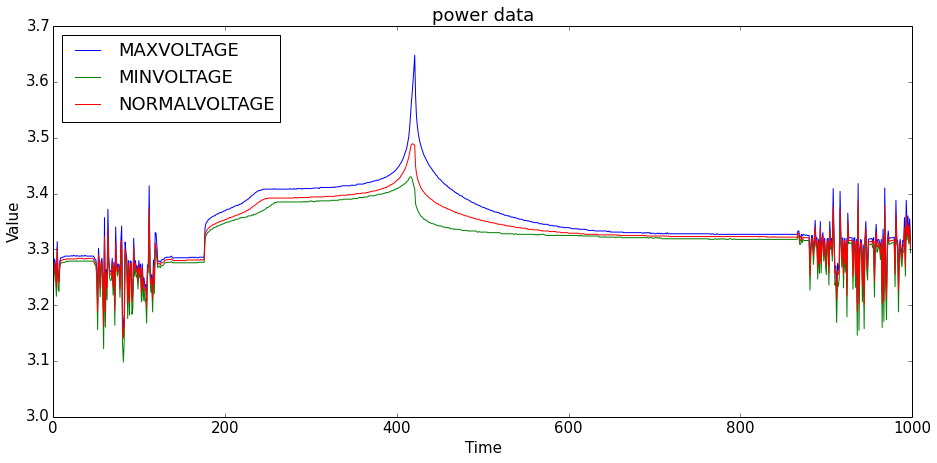

In [18]:
# visulaization of datasets
multivariate_ts_plot( dta_df[['MAXVOLTAGE','MINVOLTAGE', 'NORMALVOLTAGE']], "power data" )

multivariate_ts_plot( dta_df[['TOTALVOLTAGE']], "power data" )

multivariate_ts_plot( dta_df[['TOTALVOLTAGE','TOTALCURRENT']], "power data" )

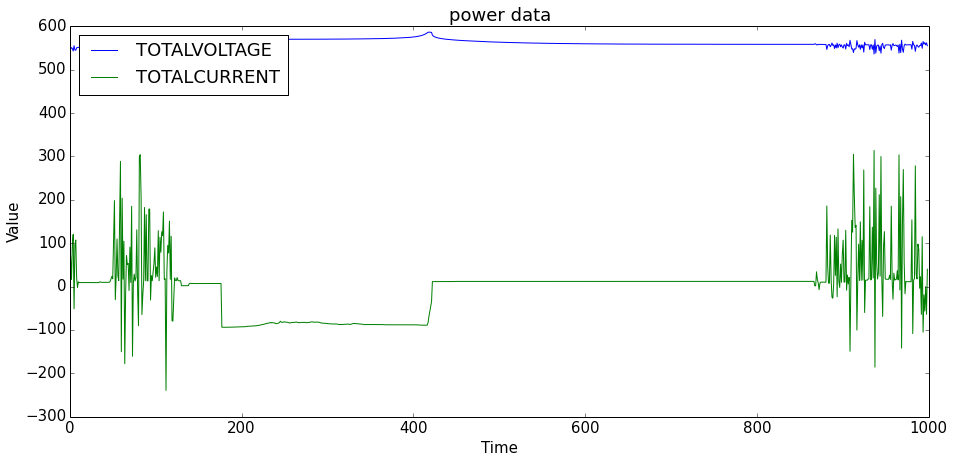

In [5]:
# CHANGE DETECTION

# test over variances
def change_detection_univariate_score_var( ts_l, ts_r):
    
    ml = mean(ts_l)
    mr = mean(ts_r)
    
    varl = var(ts_l)
    varr = var(ts_r)
    
#     print varl,varr,ts_l
    
    f_test = varl*1.0/(varr)
    p_value = sp.stats.f.cdf(f_test, len(ts_l), len(ts_r))
    
    return p_value

# test over means
def change_detection_univariate_score_mean( ts_l, ts_r):
    
    ml = mean(ts_l)
    mr = mean(ts_r)
    
    varl = var(ts_l)
    varr = var(ts_r)
    
#     tmp_std = ( (len(ts_l)-1.0)*varl + (len(ts_r)-1.0)*varr )/( len(ts_l)+len(ts_r)-2.0 )
#     t_test  = (ml-mr)*1.0/tmp_std/sqrt( 1.0/len(ts_l)+1.0/len(ts_l) ) 
    
    return sp.stats.ttest_ind( ts_l, ts_r )[1]
    
def change_detection_univariate( ts_list,  ):
    
    h = len(ts_list)
    pre_cutoff = 0
    i = 0
    
    cutoff_list = []
    
    while i < h:
        
        if i-pre_cutoff < min_len:
            i+=1
            continue
        
        tmp_score = []
        for j in range(pre_cutoff+4, i):
            
            mean_score = change_detection_univariate_score_mean(ts_list[pre_cutoff+1:j], ts_list[j:i+1])
            var_score  = change_detection_univariate_score_var(ts_list[pre_cutoff+1:j], ts_list[j:i+1]) 
            
            print mean_score, var_score, '\n'
            
            if var_score <= 0.001 or var_score >= 0.999:  
#             mean_score <= 0.01: 
#             or (   var_score <= 0.01 or var_score >= 0.99  ):
                cutoff_list.append(j)
                pre_cutoff = j
                
                break
                
#             tmp_score.append( change_detection_univariate_score(ts_list[pre_cutoff+1:j], ts_list[j:i+1]) )        
    
    return cutoff_list 

def change_detection_multivariate( ts_list, start_bias, min_len ):
    return 0.0


def change_detection_univariate_win_statis( ts_list, win_size ):
    
    i = 0
    cnt = len(ts_list)/win_size 
    win_statis = []
    
    for i in range(cnt):
        tmpdta = ts_list[ i*win_size: (i+1)*win_size ]
        win_statis.append( ( i*win_size, mean(tmpdta), var(tmpdta)) )
        
    tmpdta = ts_list[ cnt*win_size: ]
    win_statis.append( ( cnt*win_size, mean(tmpdta), var(tmpdta)) )
    
    return win_statis


# CHANGE POINT DETECTION

# mean and variacne test based approaches:
# not suitable for long sequence, minor change in mean/variance is siginificant for long sequences. 

# compare pre and merged
win_statis = change_detection_univariate_win_statis( list(dta_df[ 'TOTALCURRENT' ]), 20 )

cnt = len(win_statis)
dta = list(dta_df[ 'TOTALCURRENT' ])

prel=0
prer=0

for i in range(1,cnt-1):
    
    prer = win_statis[i][0]
    predta = dta[prel:prer]
    
    premean = mean(predta)
    prevar  = var(predta)
    
    cur_dta = dta[ win_statis[i][0]:win_statis[i+1][0] ]
    
    merged_r = win_statis[i+1][0]
    merged_dta = dta[prel:merged_r]
    
    merged_mean = mean(merged_dta)
    merged_var  = var(merged_dta)
        
    f_test = merged_var*1.0/(prevar)
    var_pval  = sp.stats.f.cdf(f_test, len(merged_dta), len(predta))
    
    
    mean_pval = sp.stats.ttest_ind( predta, cur_dta, equal_var= False )[1]
    
    
    if mean_pval< 0.01:
        prel = win_statis[i][0]
        print 'mean', prel, premean, len(predta), mean(cur_dta)
    
    elif var_pval < 0.01 or var_pval > 0.99:
        prel = win_statis[i][0]
        
        print 'var', prel, prevar, merged_var
    
        
# compare pre and cur
win_statis = change_detection_univariate_win_statis( list(dta_df[ 'TOTALCURRENT' ]), 20 )

print win_statis

cnt = len(win_statis)
dta = list(dta_df[ 'TOTALCURRENT' ])

prel=0
prer=0

for i in range(1,cnt-1):
    
    prer = win_statis[i][0]
    predta = dta[prel:prer]
    
    premean = mean(predta)
    prevar  = var(predta)
    
    cur_dta = dta[ win_statis[i][0]:win_statis[i+1][0] ]
    curmean = mean(cur_dta)
    curvar  = var(cur_dta)
        
    f_test = curvar*1.0/(prevar)
    var_pval  = sp.stats.f.cdf(f_test, len(cur_dta), len(predta))
    
    mean_pval = sp.stats.ttest_ind( predta, cur_dta )[1]
    
    if mean_pval< 0.01:
        prel = win_statis[i][0]
        print 'mean', prel, premean, curmean
    
    elif var_pval < 0.01 or var_pval > 0.99:
        prel = win_statis[i][0]
        print 'var', prel, prevar, curvar
    

In [ ]:
# CHANGE POINT DETECTION

# Dynamic programming paradigm
for c in range(C):
    
    for i in range(n):
        
        f[i][c- vol[i]]

for i in range(n):
    for c in range(C):
        f[i][]
        
for c in range(C):
    for i in range(n):
        
        f[i][c] = max(f[i-1][c- vol[i] ], f[i-1][c]) 
    
for i in range(n):
    for c in range(C):
        f[i][c] = max( f[i-1][c-vol[i]],  f[i-1][c] )

for i in range(n):
    for c in range(C, vol[i],-1):
        f[c] = max(f[c-vol[i], f[c]])
        
for i in range(c):
    for c in range(C):
        
        f[c] = max(f[c-vol[i], f[c]])
        

In [ ]:
# CHANGE POINT DETECTION

# Bayes approach

# posterior of change point number 
# variant of Viterbi algorithm
# global optimization via dynamic programming

# maximum likelihood
def lk_cal( dta ):
    
    m = mean(dta)
    v = var(dta)
    return sum([log(sp.stats.norm.pdf(tmpx, m, sqrt(v))) for tmpx in dta])

# learning
dta = list(dta_df[ 'TOTALCURRENT' ])
num = len(dta)

# number of change points
M = 15
# minmum amount of data in one segment
min_len = 60

f_lk  = [ [0 for i in range(M+1)] for _ in range(num+1) ]
f_pos = [ [0 for i in range(M+1)] for _ in range(num+1) ]

# initialize state functions
for j in range(M+1):
    f_lk[0][j] = 0.0    
    
for i in range(min_len):
    for j in range(M+1):
        f_lk[i][j] = lk_cal(dta[ :i+1])

for i in range(num):
    f_lk[i][0] = lk_cal(dta[ :i+1])
        
        
# main loop   
for end_pos in range(min_len, num):
    
    print end_pos
    
#   constraints on real scale
    for num_seg in range(1,M+1):
        
        tmp = []
        
#       speed up trick
        for seg_pos in range( 20, end_pos-25, 5 ):
            
            tmplk = lk_cal(dta[seg_pos:end_pos+1])
            
            if tmplk>0:
                print "---", seg_pos, end_pos
            
            tmp.append( (seg_pos, (tmplk + f_lk[seg_pos-1][num_seg-1]) ) )    
            
        
        tmp_tuple = max(tmp, key = lambda x: x[1])
        f_lk[end_pos][num_seg]  = tmp_tuple[1]
        f_pos[end_pos][num_seg] = tmp_tuple[0]
        
print f_lk[num-1]
    
    
    
# # inference 
# cutoff_set = []
# tmp_pos = num-1
# for i in range(M,0,-1):
#     cutoff_set.append(f_pos[tmp_pos][i])
#     tmp_pos = f_pos[tmp_pos][i]-1

    
# # posterior of M
# M_range = 10
# lk_list = []
# for i in range(1, M_range):
#     lk_list.append( (i, lk) )
    
# tmpsum = sum(lk_list)    
# posterior_m = [i*1.0/tmpsum for i in lk_list]
    

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
--- 140 166
167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
--- 140 167
168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
--- 140 168
169
--- 140 169
--- 140 169
--- 140 169
--- 140 169
--- 140 169


In [13]:
cutoff_set = []
tmp_pos = num-1
for i in range(14,0,-1):
    cutoff_set.append(f_pos[tmp_pos][i])
    tmp_pos = f_pos[tmp_pos][i]-1
print cutoff_set

[219, 177, 149, 122, 84, 51, 20, 0, 0, 0, 0, 0, 0, 0]


In [20]:
for i in range(M+1):
    print f_lk[num-1][i]

0
-55.9748344257
-100.000028629
-103.474090325
-193.28628341
-350.908776459


In [23]:
for i in range( 30, 150 ):
        
        tmpl = dta[ 30-10 : i]
        tmpr = dta[ i : 150]
    
        ml = mean(tmpl)
        vl = var(tmpl)
    
        mr = mean(tmpr)
        vr = var(tmpr)
    
        lk_l = sum([ log(sp.stats.norm.pdf(tmpx, ml, sqrt(vl))) for tmpx in tmpl])
        lk_r = sum([ log(sp.stats.norm.pdf(tmpx, mr, sqrt(vr))) for tmpx in tmpr])
        
        print i, lk_l+lk_r


In [32]:
# CHANGE POINT DETECTION

# Greedy approach based on likelihood test
dta = list(dta_df[ 'TOTALCURRENT' ])
num = len(dta)

step = 35

st_search = 0
st_window = 0

cutoff_set = []

for i in range( step, num, step ):
    
    tmplk = []
    for j in range( st_window, i ):
        
        tmpl = dta[st_window : j]
        tmpr = dta[j : i]
    
        ml = mean(tmpl)
        vl = var(tmpl)
    
        mr = mean(tmpr)
        vr = var(tmpr)
    
#         lk_l = sum([ min(log(sp.stats.norm.pdf(tmpx, ml, sqrt(vl))), 0.0) for tmpx in tmpl])
#         lk_r = sum([ min(log(sp.stats.norm.pdf(tmpx, mr, sqrt(vr))), 0.0)  for tmpx in tmpr])
        
        lk_l = sum([ log(sp.stats.norm.pdf(tmpx, ml, sqrt(vl))) for tmpx in tmpl])
        lk_r = sum([ log(sp.stats.norm.pdf(tmpx, mr, sqrt(vr)))  for tmpx in tmpr])
        
        tmplk.append( (j, lk_l+lk_r) )
    
    ref_dta = dta[st_window : i]
    ref_m = mean(ref_dta)
    ref_v = var(ref_dta)
    ref_lk = sum([ log(sp.stats.norm.pdf(tmpx, ref_m, sqrt(ref_v))) for tmpx in ref_dta ])
    
    tmplk_min = min(tmplk, key = lambda x: x[1])[1]
    tmplk_max = max(tmplk, key = lambda x: x[1])[1]
    
    tmpidx = max(tmplk, key = lambda x: x[1])[0]
    
#     print "---", st_window, st_search, i, tmplk_min, tmplk_max, ref_lk
    
    if abs(ref_lk-tmplk_max) > 0.3*abs(ref_lk):
        
        st_window = tmpidx
        cutoff_set.append( tmpidx )
       
        print tmpidx, st_window, ref_lk, tmplk_max
    
    st_search = i   
    

--- 0 0 35 -176.083519582 -34.8590118405 -176.083519582
11 11 -176.083519582 -34.8590118405
--- 11 35 70 -330.93435231 -159.65855354 -330.93435231
47 47 -330.93435231 -159.65855354
--- 47 70 105 -350.085678303 -338.912897651 -350.085678303
--- 47 105 140 -553.174613711 -512.631698757 -553.174613711
--- 47 140 175 -743.61653817 -528.429838643 -743.61653817
--- 47 175 210 -960.629464239 -790.257842199 -960.629464239
--- 47 210 245 -1166.17430328 -941.079257294 -1166.17430328
--- 47 245 280 -1365.11225844 -1059.22531105 -1365.11225844
--- 47 280 315 -1561.14658151 -1153.10738258 -1561.14658151
--- 47 315 350 -1755.03998189 -1235.44080303 -1755.03998189
--- 47 350 385 -1946.83133748 -1315.24688437 -1946.83133748
177 177 -1946.83133748 -1315.24688437
--- 177 385 420 -685.070873665 -591.326431501 -685.070873665
--- 177 420 455 -1359.40899921 -759.359487977 -1359.40899921
422 422 -1359.40899921 -759.359487977
--- 422 455 490 12.8310185565 83.6298207006 12.8310185565
455 455 12.8310185565 83.6

In [ ]:
# Segmentation and Labelling

# HMM hidden markov model
from hmmlearn import hmm

def parse_hidden_states_hmm( hstates ):
    
    seg = []
    cutoff = []
    
    cnt = len(z)
    
    pre = 0
    for i in range(1,cnt):
        if z[i]!=z[i-1]:
            seg.append( (z[i-1], pre, i-1) )
            pre = i
            
            cutoff.append( i )
            
    seg.append((z[cnt-1], pre, cnt-1))
    
    return seg, cutoff


dta = np.array(dta_df[ 'TOTALCURRENT' ])
dta = np.reshape(dta, [-1,1] )
print np.shape(dta)

seg_model = hmm.GaussianHMM(n_components = 3, covariance_type="full", n_iter=500, verbose= False)
seg_model.fit(dta)  

z = seg_model.predict(dta)

seg_set, cutoff_set = parse_hidden_states_hmm( z )

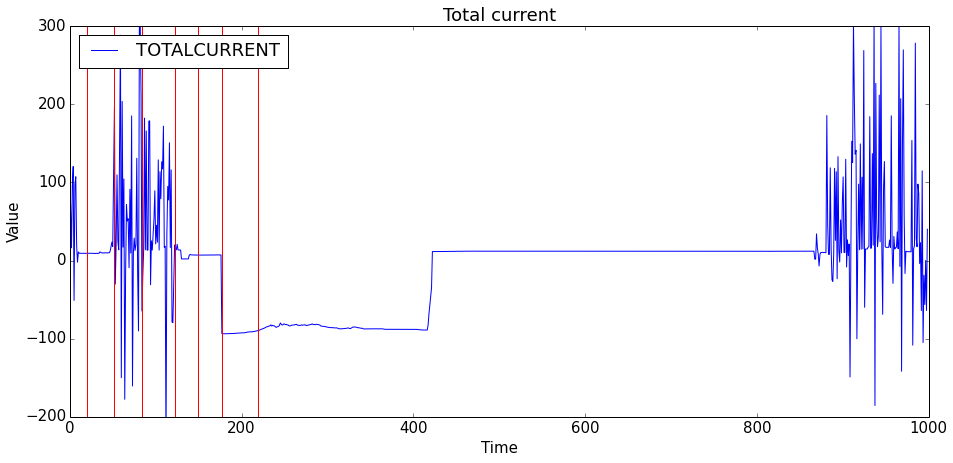

In [34]:
# visualiation of change detection and segmentation

multivariate_ts_plot( dta_df[['TOTALCURRENT']], "Total current" )

cutoff_set = [219, 177, 149, 122, 84, 51, 20, 0]

for i in cutoff_set:
    plt.axvline(x=i, color = 'red')


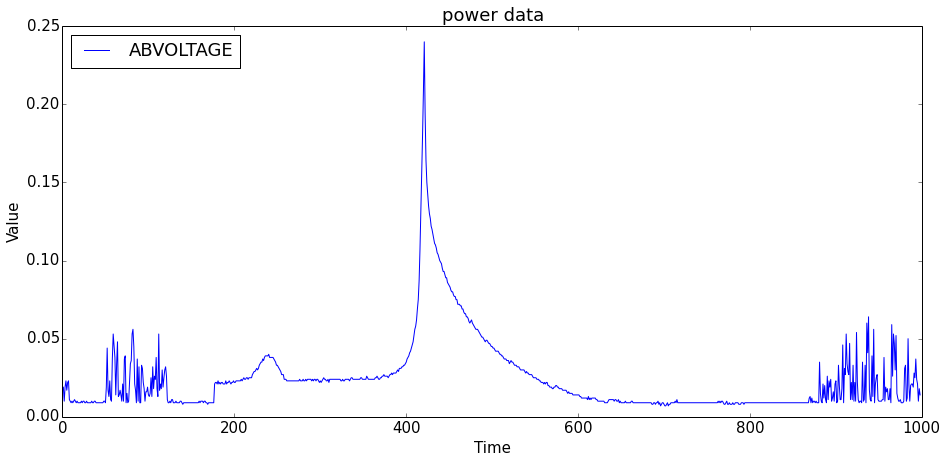

In [7]:
multivariate_ts_plot( dta_df[['ABVOLTAGE']], "power data" )

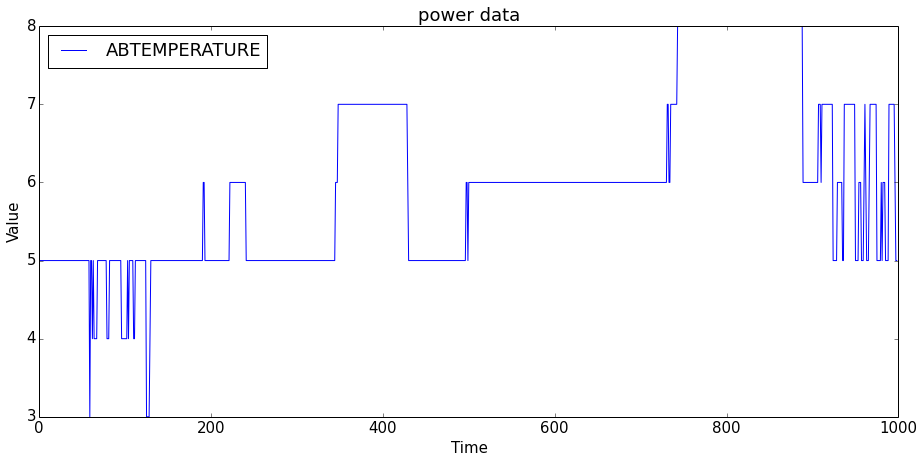

In [8]:
multivariate_ts_plot( dta_df[['ABTEMPERATURE']], "power data" )

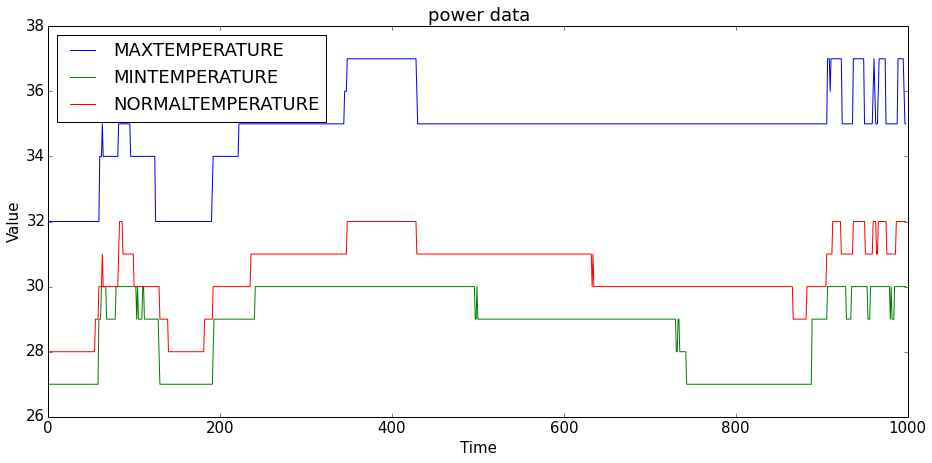

In [20]:
 multivariate_ts_plot( dta_df[['MAXTEMPERATURE','MINTEMPERATURE', 'NORMALTEMPERATURE']], "power data" )

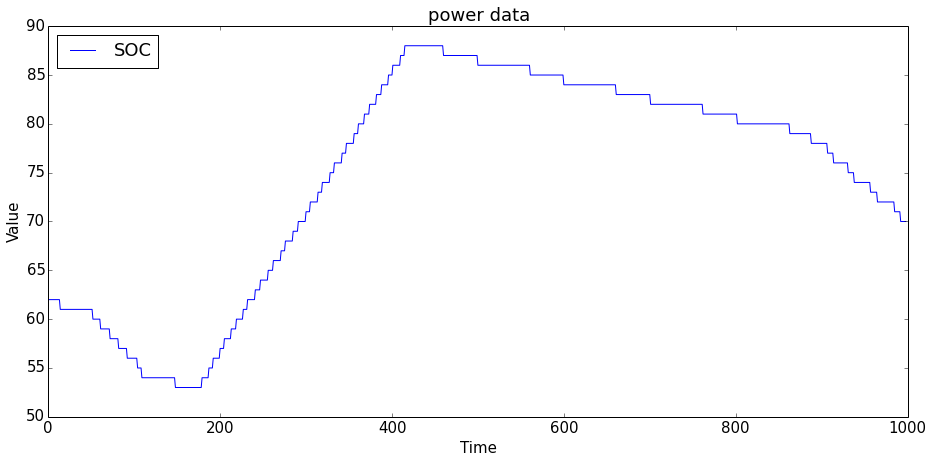

In [9]:
multivariate_ts_plot( dta_df[['SOC']], "power data" )